In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import sktime
from sklearn.manifold import TSNE

In [2]:
# load raw data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")
# fft and smooth our data to reduce noise
data_fft = fft.fft(data)[:,:,::2]
# load receiver positions
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")
# load transmitter positions
tx_positions = np.load("../Data/RayTracingData/Remcom_4x4_txpos.npy")
# load Phi and Theta
phi = np.load('../Data/RayTracingData/Remcom_4x4_AoA_phi.npy')
theta = np.load('../Data/RayTracingData/Remcom_4x4_AoA_theta.npy')

In [43]:
def standarize(x):
    return (np.array(x)-np.mean(x))/np.std(x)

def euclidean_distance(x1,x2):
    return np.linalg.norm(x1-x2)

def drop_top_right(data, rx_positions):
    idxx = rx_positions[:,0] > 300
    idxy = rx_positions[:,1] > 150
    idx = np.logical_and(idxx, idxy)
    good_idcs = ~idx
    return data[good_idcs]
def normalize(x):
    return (x - x.min(0))/x.ptp(0)

def fillna(x, value=0):
    x[np.where(np.isnan(x))] = value
    return x

def zero_padding_as(x, target):
    width = (target.shape[2] - x.shape[2])//2
    x = np.pad(x, (width,width))
    return x

In [57]:
X_1 = standarize(drop_top_right(data_fft, rx_positions))
X_1 = np.hstack([np.real(X_1), np.imag(X_1)])
X_2 = zero_padding_as(fillna(standarize(drop_top_right(phi, rx_positions)))[10:], X_1)
X_3 = zero_padding_as(fillna(standarize(drop_top_right(theta, rx_positions)))[10:], X_1)

In [132]:
X = np.hstack([X_1])
Y = drop_top_right(standarize(rx_positions)[:,:2], rx_positions)

train_X, test_X, train_y, test_y = train_test_split(X,Y, test_size=0.9)

In [138]:
tsne = TSNE(n_components=2, perplexity=10, n_jobs=-1)

In [134]:
import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from src.utils.metrics import distance_matrix
#from mtsne.mtsne import *

In [215]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum(x - y)**2)

def distance_matrix(X):
    d_mat = np.zeros((len(X), len(X)))
    for j in range(len(X)):
        d_mat[j] = np.array([euclidean_distance(X[j], X[i]) for i in range(len(X))])
    return d_mat


In [216]:
dmat = distance_matrix(train_X)
real_dmat = distance_matrix(train_y)

In [217]:
manifolds = []
for per in [5, 10, 30, 50, 100]:
    tsne = TSNE(n_components=2, perplexity=per, n_jobs=-1)
    Y = tsne.fit_transform(dmat)
    manifolds.append(Y)

In [228]:
space_manifolds = []
for per in [5, 10, 30, 50, 100]:
    tsne = TSNE(n_components=2, perplexity=per, n_jobs=-1)
    Y = tsne.fit_transform(real_dmat)
    space_manifolds.append(Y)

In [193]:
distance_from_x = real_dmat[1000]


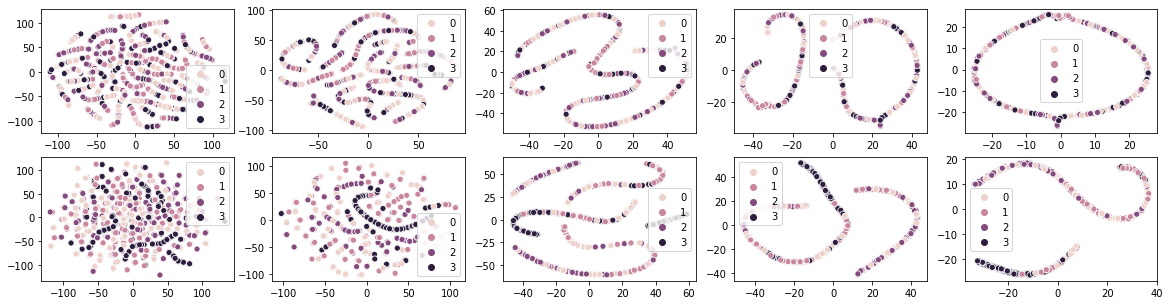

In [251]:
import seaborn as sns
plt.figure(figsize=(20,5))
for i, Y in enumerate(manifolds):
    plt.subplot(2,5,i+1)
    sns.scatterplot(Y[:,0], Y[:,1], hue=labels)
for i, Y in enumerate(space_manifolds):
    plt.subplot(2,5,i+6)
    sns.scatterplot(Y[:,0], Y[:,1], hue=labels)

In [233]:
from sklearn.cluster import KMeans

In [247]:
km = KMeans(n_clusters=8)
km = km.fit(train_y)

In [248]:
km.cluster_centers_

array([[ 0.17338005,  0.50650598],
       [ 1.57095162, -1.22535515],
       [ 1.63098084, -0.12889659],
       [-0.05669024, -1.00410321]])

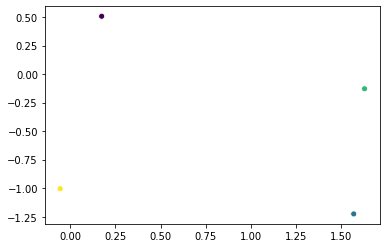

In [249]:
sns.scatterplot(km.cluster_centers_[:,0], km.cluster_centers_[:,1])

In [250]:
labels = km.predict(train_y)

{0, 1, 2, 3, 4, 5, 6, 7}